In [133]:
# 10-21-2025

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf


import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.layers import Normalization
from tensorflow.keras.optimizers import Adam


from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split

In [2]:
fires = pd.read_csv("../synthetic_fires/fires_smogn.csv")

In [3]:
fires.head()

,FIRE_YEAR,FIRE_SIZE,LATITUDE,LONGITUDE,temp_max_F,humidity_pct,precip_in,windspeed_mph,ndvi,pop_density,slope
0,2008.0,60.026144,33.120652,-115.470841,76.122085,66.0,0.000000,7.709415,925.894234,0.030405,0.000000
1,2009.0,45.414847,34.160982,-118.759623,89.364895,81.0,0.000000,5.090490,3507.904432,653.045072,264.541299
2,2007.0,59.154930,33.961713,-117.219707,80.965517,60.0,0.000000,7.560573,2701.124940,62.490938,608.347391
3,2008.0,56.220472,33.920497,-117.098855,91.666924,68.0,0.000000,6.765826,2470.000000,2.840684,516.297300
4,2009.0,51.333333,34.508497,-118.088987,80.392702,55.0,0.004306,6.366584,4531.775450,0.591940,1458.844625


In [4]:
fires.describe()

,FIRE_YEAR,FIRE_SIZE,LATITUDE,LONGITUDE,temp_max_F,humidity_pct,precip_in,windspeed_mph,ndvi,pop_density,slope
count,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000
mean,2009.228836,1921.004049,33.887747,-117.395677,84.732663,66.338624,0.003621,8.168879,3216.703757,214.656759,651.713611
std,2.862550,13114.965686,0.606454,0.994762,10.167436,18.787507,0.020709,2.454898,1174.483610,589.759968,423.244398
min,2005.000000,2.000000,32.552700,-120.574722,43.520000,11.000000,0.000000,2.548167,-3000.000000,0.000000,-70.337070
25%,2007.000000,8.000000,33.533790,-118.011148,78.440000,53.000000,0.000000,6.650093,2359.673615,0.568079,348.728845
50%,2009.000000,75.000000,33.927302,-117.219081,85.460000,67.000000,0.000000,7.682434,3073.678352,9.791229,584.171361
75%,2011.000000,230.250000,34.336932,-116.871789,91.760000,82.000000,0.000000,9.198260,4078.796855,76.853848,902.724540
max,2015.000000,240207.000000,34.991878,-114.203000,118.400000,100.000000,0.551181,20.758235,6407.000000,4998.376465,2481.707300


In [5]:
fires = fires.sample(frac=1, random_state = 5)

In [6]:
print(np.isinf(fires).sum())

FIRE_YEAR        0
FIRE_SIZE        0
LATITUDE         0
LONGITUDE        0
temp_max_F       0
humidity_pct     0
precip_in        0
windspeed_mph    0
ndvi             0
pop_density      0
slope            0
dtype: int64


<Axes: xlabel='FIRE_SIZE', ylabel='Count'>

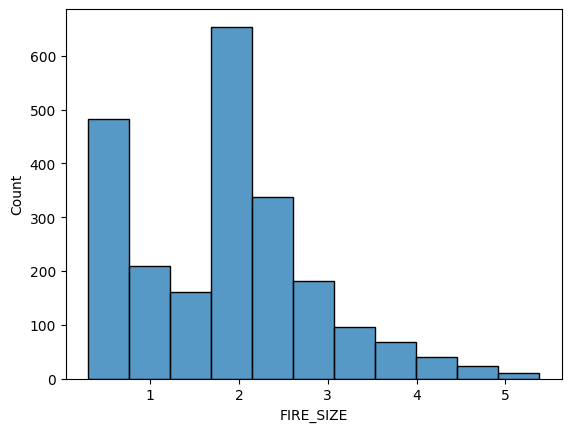

In [7]:
sns.histplot(data=np.log10(fires["FIRE_SIZE"]), bins=11, kde=False)

<Axes: >

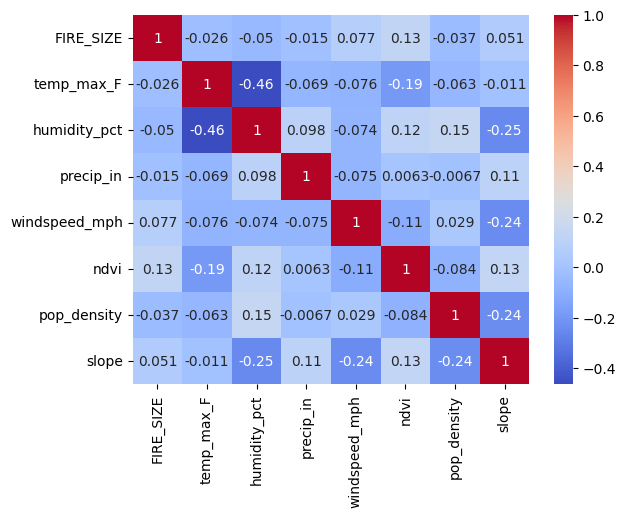

In [8]:
corr = fires[["FIRE_SIZE","temp_max_F","humidity_pct","precip_in","windspeed_mph","ndvi","pop_density","slope"]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

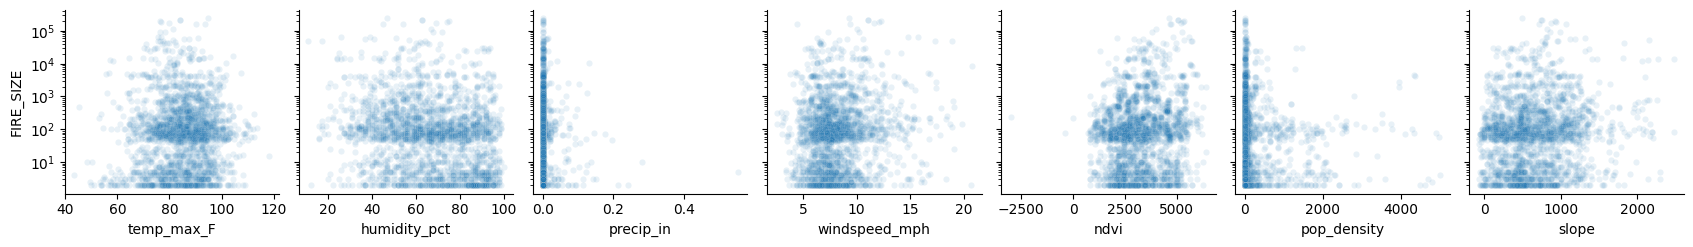

In [9]:
g = sns.pairplot(
    fires,
    x_vars=["temp_max_F", "humidity_pct", "precip_in", "windspeed_mph", "ndvi", "pop_density","slope"],
    y_vars=["FIRE_SIZE"],
    plot_kws={"alpha": 0.1, "s": 20}
)

# Set y-axis to log scale
for ax in g.axes[:, 0]:  # first (and only) column of axes
    ax.set_yscale("log")

plt.show()
# semi log shows streaks in data

In [10]:
fires_data = fires[["FIRE_SIZE","temp_max_F", "humidity_pct", "precip_in", "windspeed_mph", "ndvi", "pop_density","slope"]].copy()
fires_data

,FIRE_SIZE,temp_max_F,humidity_pct,precip_in,windspeed_mph,ndvi,pop_density,slope
1200,150.0,76.64,86.0,0.0,9.633313,2638.0,297.180756,143.354950
866,645.0,94.10,51.0,0.0,7.147296,3958.0,1.282237,568.764340
2130,80.0,88.34,33.0,0.0,12.740833,1386.0,0.000000,1139.315900
1376,6.0,74.66,98.0,0.0,8.328154,2050.0,793.120544,419.773930
1763,3.1,99.86,81.0,0.0,6.650093,3372.0,3600.464355,342.488000
...,...,...,...,...,...,...,...,...
1032,50.0,91.40,72.0,0.0,6.712244,5196.0,4.904080,370.977260
2121,7.2,84.02,65.0,0.0,9.011809,2185.0,0.612813,620.171260
1424,110.0,113.54,33.0,0.0,11.684276,3597.0,0.855352,72.046646
1725,42.0,82.40,80.0,0.0,8.141703,3471.0,882.793518,762.268250


In [11]:
fires_data["FIRE_SIZE"] = np.log10(fires_data["FIRE_SIZE"])

In [12]:
print(np.isinf(fires_data).sum())

FIRE_SIZE        0
temp_max_F       0
humidity_pct     0
precip_in        0
windspeed_mph    0
ndvi             0
pop_density      0
slope            0
dtype: int64


In [13]:
fires_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows that now contain NaN
fires_data = fires_data.dropna()

<Axes: xlabel='temp_max_F', ylabel='Count'>

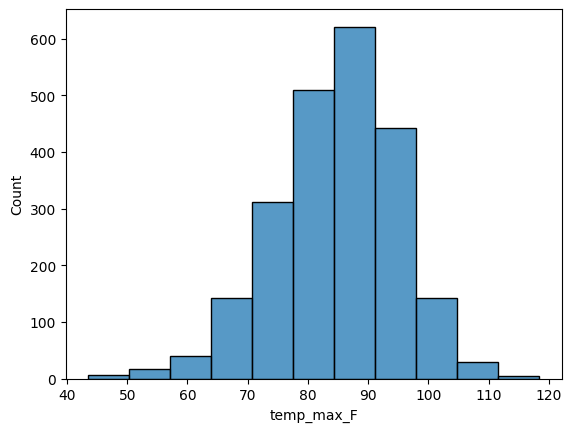

In [14]:
sns.histplot(data=fires_data["temp_max_F"], bins=11, kde=False)
# temp is normal dist

<Axes: xlabel='humidity_pct', ylabel='Count'>

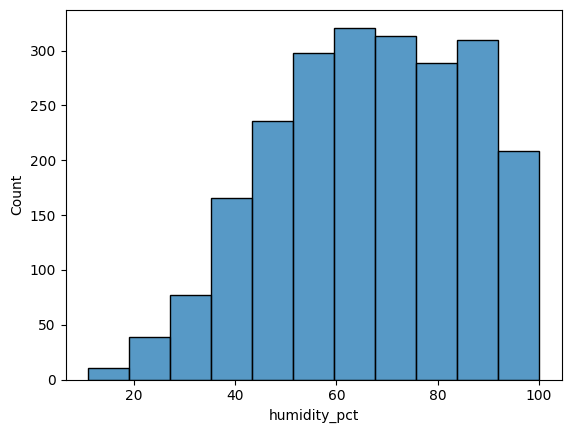

In [15]:
sns.histplot(data=fires["humidity_pct"], bins=11, kde=False)
# humidity is normal dist

<Axes: xlabel='precip_in', ylabel='Count'>

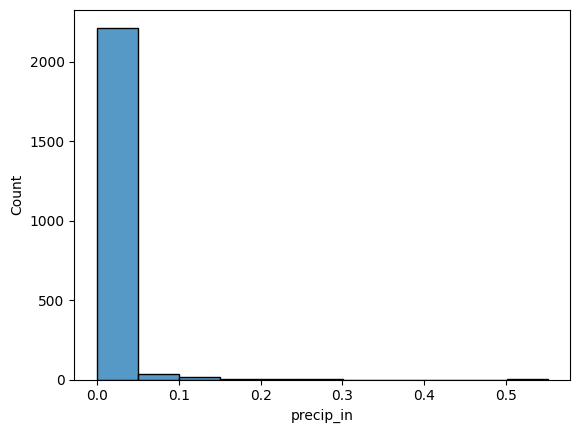

In [16]:
sns.histplot(data=fires["precip_in"], bins=11, kde=False)
# precip is power dist

<Axes: xlabel='windspeed_mph', ylabel='Count'>

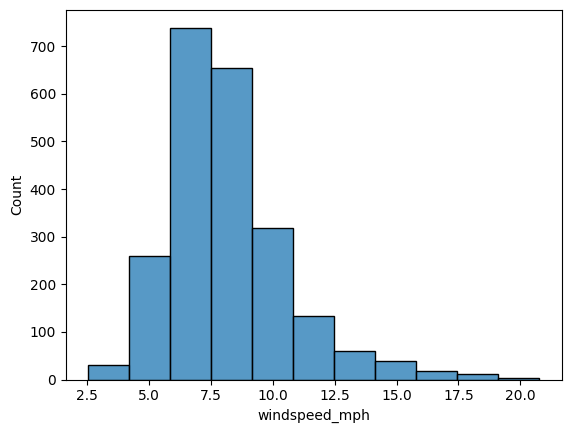

In [17]:
sns.histplot(data=fires["windspeed_mph"], bins=11, kde=False)
# windspeed is normal dist

<Axes: xlabel='ndvi', ylabel='Count'>

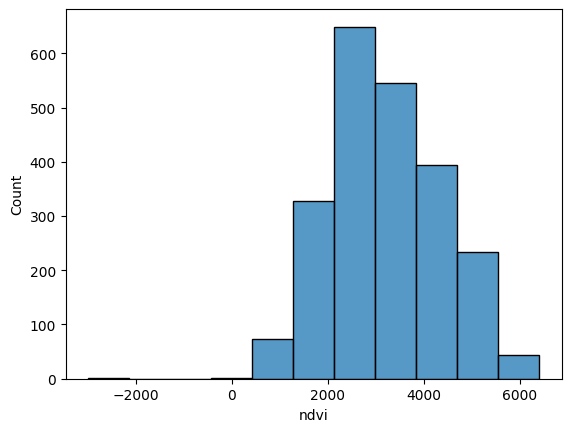

In [18]:
sns.histplot(data=fires["ndvi"], bins=11, kde=False)
# ndvi is normal dist

<Axes: xlabel='pop_density', ylabel='Count'>

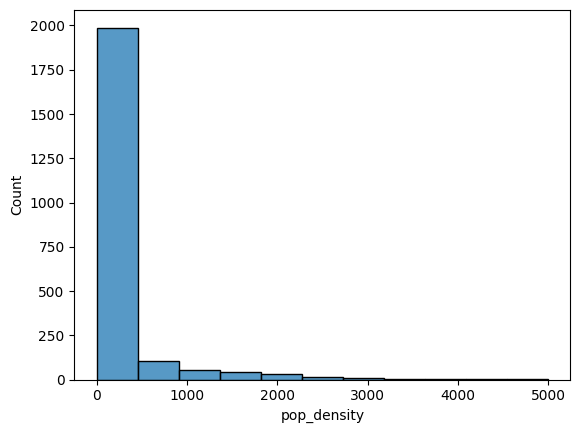

In [19]:
sns.histplot(data=fires["pop_density"], bins=11, kde=False)
# pop is power dist

<Axes: xlabel='slope', ylabel='Count'>

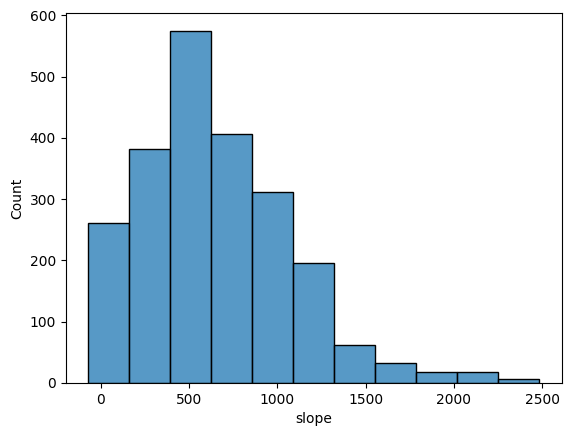

In [20]:
sns.histplot(data=fires["slope"], bins=11, kde=False)
# slope is normal dist

In [21]:
# normal: temp, humid, windspeed, ndvi, slope
# power: precip, pop_density

In [22]:
iqr_cols = ["windspeed_mph"] # not including precip bc it has such a long and small tail, everything's just gonna get clipped
zscore_cols = ["temp_max_F", "humidity_pct"]

In [23]:
for col in iqr_cols:
    Q1 = fires_data[col].quantile(0.25)
    Q3 = fires_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.9 * IQR
    upper = Q3 + 1.9 * IQR
    fires_data[col] = fires_data[col].clip(lower, upper)

In [24]:
k = 3 # 3 std from mean (99.7%)
for col in zscore_cols:
    mean = fires_data[col].mean()
    std = fires_data[col].std()
    lower = mean - k * std
    upper = mean + k * std
    fires_data[col] = fires_data[col].clip(lower, upper)

In [25]:
fires_data

,FIRE_SIZE,temp_max_F,humidity_pct,precip_in,windspeed_mph,ndvi,pop_density,slope
1200,2.176091,76.64,86.0,0.0,9.633313,2638.0,297.180756,143.354950
866,2.809560,94.10,51.0,0.0,7.147296,3958.0,1.282237,568.764340
2130,1.903090,88.34,33.0,0.0,12.740833,1386.0,0.000000,1139.315900
1376,0.778151,74.66,98.0,0.0,8.328154,2050.0,793.120544,419.773930
1763,0.491362,99.86,81.0,0.0,6.650093,3372.0,3600.464355,342.488000
...,...,...,...,...,...,...,...,...
1032,1.698970,91.40,72.0,0.0,6.712244,5196.0,4.904080,370.977260
2121,0.857332,84.02,65.0,0.0,9.011809,2185.0,0.612813,620.171260
1424,2.041393,113.54,33.0,0.0,11.684276,3597.0,0.855352,72.046646
1725,1.623249,82.40,80.0,0.0,8.141703,3471.0,882.793518,762.268250


In [200]:
fires_data.columns.to_list()

['FIRE_SIZE',
 'temp_max_F',
 'humidity_pct',
 'precip_in',
 'windspeed_mph',
 'ndvi',
 'pop_density',
 'slope']

In [201]:
X = fires_data.drop("FIRE_SIZE", axis=1)
y = fires_data["FIRE_SIZE"]

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [203]:
power_cols = ["precip_in", "pop_density"]
standard_cols = ["temp_max_F", "humidity_pct", "windspeed_mph", "ndvi","slope"]
# normal: temp, humid, windspeed, ndvi, slope
# power: precip, pop_density

# whats interesting is that before smogn, windspeed was a power dist, but now is normal

In [204]:
std_scaler = StandardScaler()
pwr_scaler = PowerTransformer()

In [205]:
X_train[standard_cols] = std_scaler.fit_transform(X_train[standard_cols])
X_train[power_cols] = pwr_scaler.fit_transform(X_train[power_cols])

X_test[standard_cols] = std_scaler.transform(X_test[standard_cols])
X_test[power_cols] = pwr_scaler.transform(X_test[power_cols])

In [ ]:
# X_train.to_csv("X_train.csv", index=False)
# y_train.to_csv("y_train.csv", index=False)

# X_test.to_csv("X_test.csv", index=False)
# y_test.to_csv("y_test.csv", index=False)

In [165]:
X_train

,temp_max_F,humidity_pct,precip_in,windspeed_mph,ndvi,pop_density,slope
2007,0.729943,0.103343,-0.306948,-0.070161,-0.271251,1.288017,0.154438
137,1.309252,-1.605737,-0.306948,-1.074095,-1.601398,-0.916982,0.767691
489,1.329067,-0.430744,-0.306948,-0.680834,-1.012663,0.284322,0.651397
810,0.962344,0.637431,-0.306948,-0.098546,0.104404,1.514898,-0.930010
979,0.193632,0.103343,-0.306948,1.207180,0.610423,-0.107723,-0.098976
...,...,...,...,...,...,...,...
1198,0.640558,1.011292,3.827339,-0.126932,-0.136599,0.292395,0.440507
1205,0.122124,1.171519,-0.306948,0.809785,-0.465940,0.680147,-1.341478
1733,-1.039882,0.904475,-0.306948,1.235566,0.118984,1.671537,-0.889983
1478,-1.325914,1.545380,-0.306948,1.093639,0.554675,1.424380,-1.129883


In [166]:
X_train = X_train.to_numpy()

In [167]:
X_train

array([[ 0.72994258,  0.1033433 , -0.3069477 , ..., -0.27125127,
         1.28801653,  0.15443765],
       [ 1.30925218, -1.60573707, -0.3069477 , ..., -1.60139848,
        -0.91698182,  0.76769073],
       [ 1.32906679, -0.43074431, -0.3069477 , ..., -1.01266261,
         0.28432218,  0.65139708],
       ...,
       [-1.03988156,  0.90447473, -0.3069477 , ...,  0.11898373,
         1.67153671, -0.889983  ],
       [-1.32591375,  1.54537987, -0.3069477 , ...,  0.55467467,
         1.42437954, -1.12988275],
       [ 1.55228512, -1.2852845 , -0.3069477 , ..., -1.7387064 ,
        -0.69414896,  0.27954484]])

In [26]:
np.isfinite(X_train).all()

NameError: name 'X_train' is not defined

In [169]:
np.isnan(X_train).sum()

np.int64(0)

In [170]:
y_train

2007    0.301030
137     1.918197
489     2.712774
810     0.477121
979     0.477121
          ...   
1198    2.204120
1205    1.301030
1733    0.324282
1478    0.477121
2194    1.079181
Name: FIRE_SIZE, Length: 1814, dtype: float64

In [171]:
print(np.isinf(X_train).sum(), np.isinf(y_train).sum())

0 0


In [172]:
model = Sequential([
    Dense(28, activation="relu"),
    
    Dense(1)
])

In [41]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [43]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_split=0.1,
    verbose=1
)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4031 - mae: 1.4031 - val_loss: 1.1963 - val_mae: 1.1963
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0535 - mae: 1.0535 - val_loss: 1.0740 - val_mae: 1.0740
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9328 - mae: 0.9328 - val_loss: 1.0167 - val_mae: 1.0167
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8504 - mae: 0.8504 - val_loss: 0.9800 - val_mae: 0.9800
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8251 - mae: 0.8251 - val_loss: 0.9553 - val_mae: 0.9553
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8348 - mae: 0.8348 - val_loss: 0.9390 - val_mae: 0.9390
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8051 - mae: 0.8051 - val_loss: 0.9218 - val_mae: 0.9218
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7861 - mae: 0.7861 - val_loss: 0.9147 - val_mae: 0.9147
Epoch 9/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8044 - mae: 

In [44]:
loss = model.evaluate(X_test, y_test)
print(f"Test loss mae: {loss[1]}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7812 - mae: 0.7812 
Test loss mae: 0.7858926653862


In [45]:
y_pred = model.predict(X_test)
y_pred

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([[1.9998305 ],
       [2.4341483 ],
       [1.9235425 ],
       [2.1072598 ],
       [1.8008559 ],
       [1.6532366 ],
       [1.9886014 ],
       [2.1356688 ],
       [1.8070214 ],
       [1.9240632 ],
       [2.010165  ],
       [1.5761244 ],
       [1.6228683 ],
       [1.3481226 ],
       [2.120656  ],
       [1.8406746 ],
       [3.810576  ],
       [2.098437  ],
       [1.3343241 ],
       [2.155856  ],
       [1.7058008 ],
       [1.568919  ],
       [1.6780353 ],
       [1.7440953 ],
       [1.595577  ],
       [1.6971779 ],
       [1.9269235 ],
       [2.3635733 ],
       [2.034592  ],
       [2.4561827 ],
       [2.0830836 ],
       [1.4523377 ],
       [1.8215325 ],
       [1.3805623 ],
       [1.7299483 ],
       [1.8982055 ],
       [1.5205262 ],
       [1.7650023 ],
       [1.8122244 ],
       [2.2240794 ],
       [1.6531355 ],
       [2.5821064 ],
       [1.6996813 ],
       [1.8706672 ],
       [1.9219282 ],
       [1.5098281 ],
       [1.5130472 ],
       [1.828

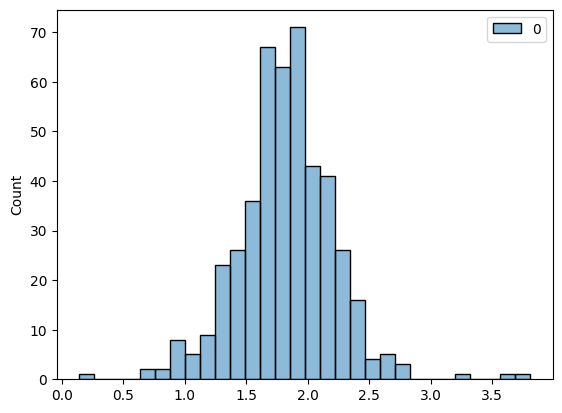

In [46]:
sns.histplot(data=y_pred, bins=30, kde=False)
plt.show()

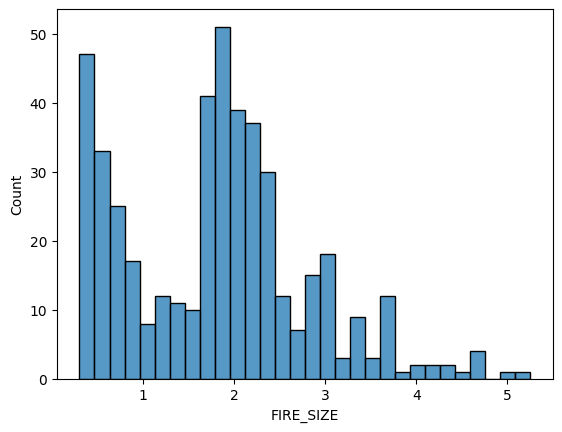

In [47]:
sns.histplot(data=y_test, bins=30, kde=False)
plt.show()

In [48]:
import shap

In [49]:
features = ['temp_max_F','humidity_pct','precip_in','windspeed_mph','ndvi','pop_density','slope']

In [50]:
background = X_test.to_numpy()
X_test_sample = X_test.to_numpy()
feature_names = X_test.columns.tolist()

In [51]:
explainer = shap.DeepExplainer(model, background)

c:\Users\Yash\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\Yash\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(454, 7))']
  warnings.warn(msg)


In [52]:
shap_values = explainer.shap_values(X_test_sample) # gives array of size (#rows,5,1)
shap_values = np.squeeze(shap_values, axis=2) # converts to (#rows,5)


c:\Users\Yash\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(908, 7))']
  warnings.warn(msg)


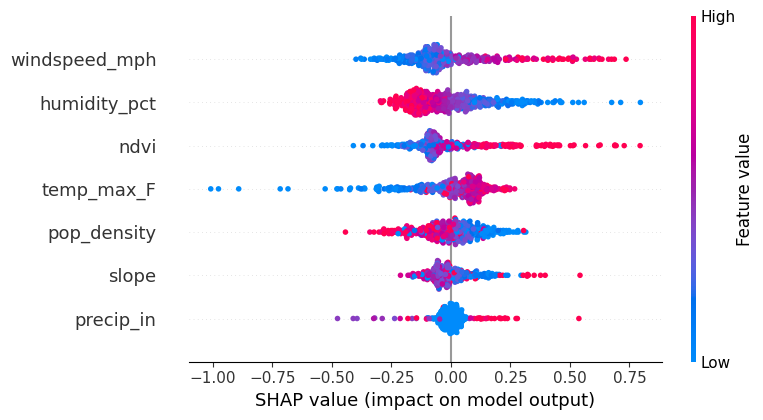

In [53]:
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names)

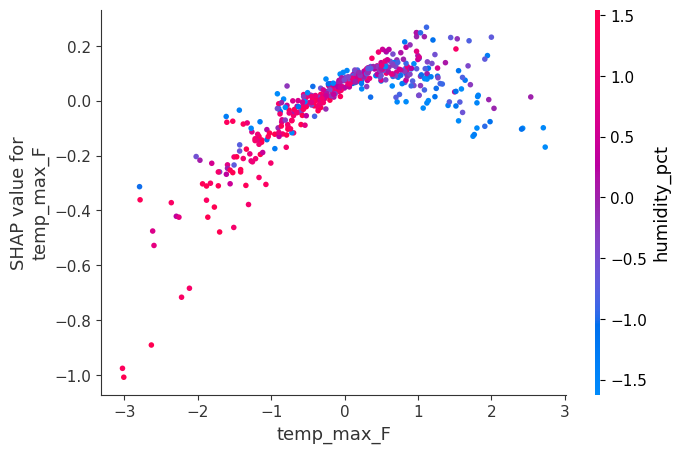

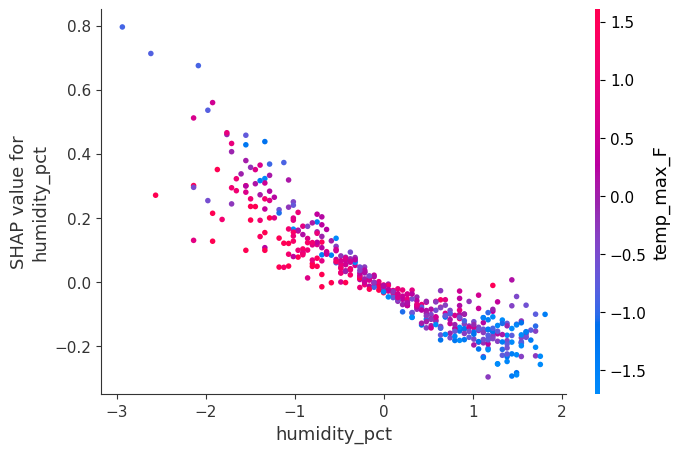

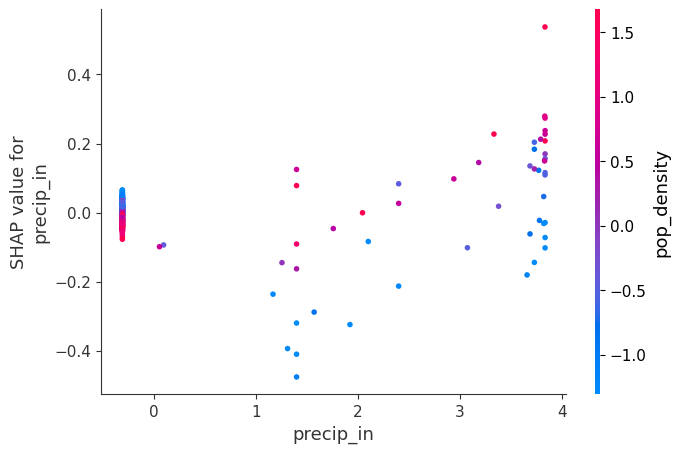

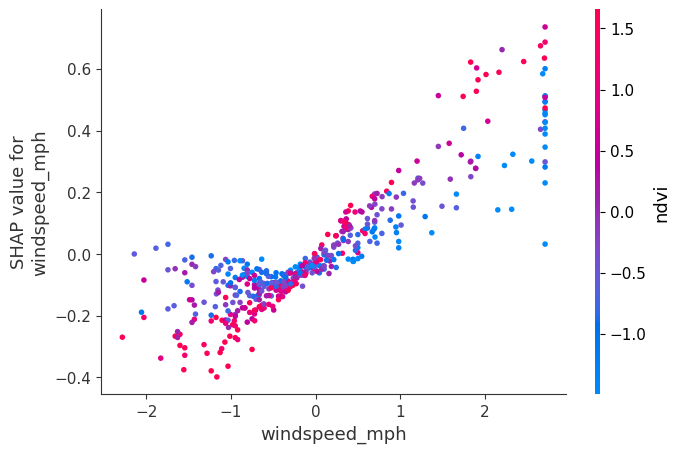

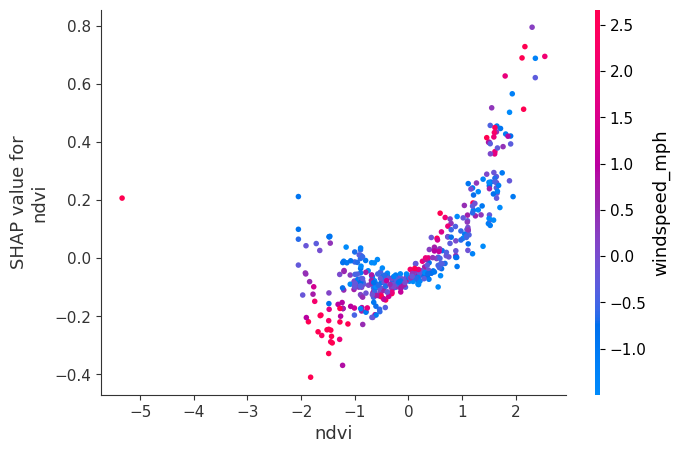

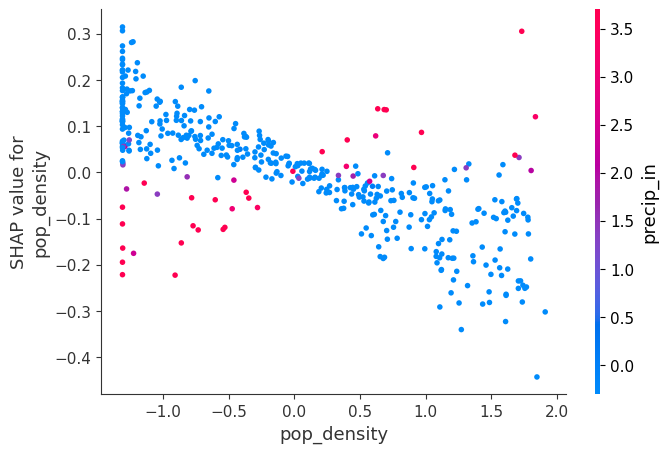

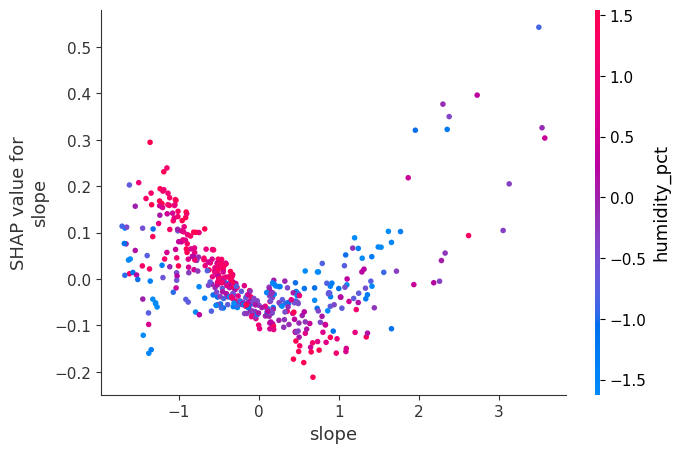

In [54]:
shap.dependence_plot("temp_max_F", shap_values, X_test, feature_names=features)
shap.dependence_plot("humidity_pct", shap_values, X_test, feature_names=features)
shap.dependence_plot("precip_in", shap_values, X_test, feature_names=features)
shap.dependence_plot("windspeed_mph", shap_values, X_test, feature_names=features)
shap.dependence_plot("ndvi", shap_values, X_test, feature_names=features)
shap.dependence_plot("pop_density", shap_values, X_test, feature_names=features)
shap.dependence_plot("slope", shap_values, X_test, feature_names=features)

In [55]:
X_train

array([[ 0.72994258,  0.1033433 , -0.3069477 , ..., -0.27125127,
         1.28801653,  0.15443765],
       [ 1.30925218, -1.60573707, -0.3069477 , ..., -1.60139848,
        -0.91698182,  0.76769073],
       [ 1.32906679, -0.43074431, -0.3069477 , ..., -1.01266261,
         0.28432218,  0.65139708],
       ...,
       [-1.03988156,  0.90447473, -0.3069477 , ...,  0.11898373,
         1.67153671, -0.889983  ],
       [-1.32591375,  1.54537987, -0.3069477 , ...,  0.55467467,
         1.42437954, -1.12988275],
       [ 1.55228512, -1.2852845 , -0.3069477 , ..., -1.7387064 ,
        -0.69414896,  0.27954484]])

In [56]:
X_test = X_test.to_numpy()
X_test

array([[ 1.75755223e-01, -9.11423167e-01, -3.06947704e-01, ...,
        -5.77435657e-01,  9.02965844e-01, -2.31593286e-01],
       [-1.67504604e-03,  2.10160827e-01, -3.06947704e-01, ...,
         2.14822175e+00,  1.84605818e+00, -1.52321006e+00],
       [ 1.80256328e+00, -1.92618964e+00, -3.06947704e-01, ...,
        -5.03676954e-01, -4.95398492e-01, -1.44016389e+00],
       ...,
       [-1.59406892e+00, -3.47421933e-03, -3.06947704e-01, ...,
         8.03890564e-02,  8.75619407e-01, -1.01137591e+00],
       [ 2.47263270e-01, -1.33869326e+00, -3.06947704e-01, ...,
        -1.90251934e+00, -6.88108450e-01, -1.20554222e+00],
       [ 1.76680925e+00, -1.33869326e+00, -3.06947704e-01, ...,
         1.87596474e-01, -2.98896644e-01, -1.34067134e+00]])

In [57]:
y_test = y_test.to_numpy()

In [58]:
from lime import lime_tabular

In [112]:

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=features,
    mode="regression"
)

In [130]:
i = 7  # index of the test sample to explain
x_instance = X_test[i]
pred_for_i = model.predict(np.array([x_instance]))
actual_i = y_test[i]

exp = explainer.explain_instance(
    data_row=x_instance,
    predict_fn=model.predict
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


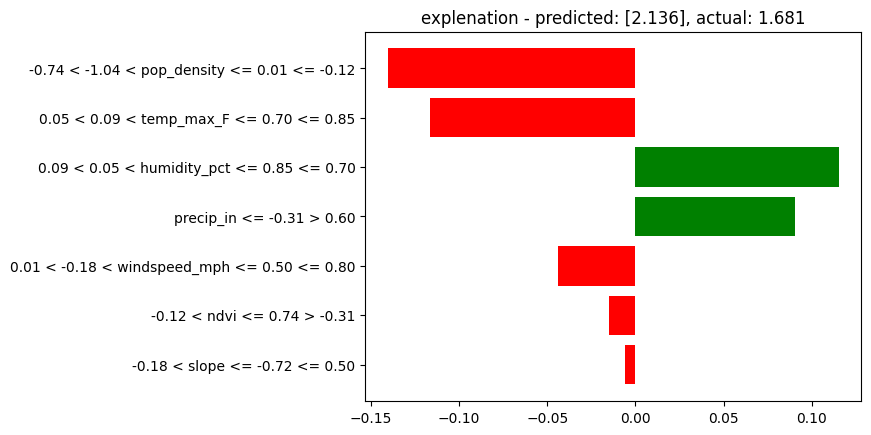

In [131]:
exp.as_pyplot_figure()
plt.title(label=f"explenation - predicted: {(np.round(pred_for_i,3))[0]}, actual: {np.round(actual_i,3)}")
plt.show()

In [132]:
from IPython.display import display, HTML

custom_css = """
<style>
    body, div, span, p, td, th, h1, h2, h3, h4, h5, h6 {
        color: white !important;
        background-color: #1e1e1e !important;
    }
    svg text {
        fill: white !important;
    }
    .tick text, .colorbar-label {
        fill: white !important;
        color: white !important;
    }
</style>
"""
# inject custom css to make the text white so that it's visible

display(HTML(custom_css + exp.as_html(show_table=True)))
#display(HTML(exp.as_html(show_table=True)))

In [126]:
# when it says humidity_pct <= -0.75, the -0.75 means standard deviations from mean of humidity, so more negative means relativey lower values for that feature
# 0.36 for humidity means its pushing the prediction up
# when it gives ranges (hum <= -0.75 or -0.74<ndvi<=-0.12) means lime is splitting feature contributions into intervals